In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b9229b1b-4f2a-09fd-0eb4-d914346a2840)


In [ ]:
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
!rm ninja-linux.zip

In [ ]:
!pip install gradio

In [10]:
import gradio as gr
import os
import sys
# TODO: change to repo after finishing
%cd "/content/drive/MyDrive/repos/art-style-challenge/extern/stylegan2-ada-pytorch"

library_paths = ['.']

import dnnlib
import legacy
import projector as projector

for p in library_paths:
    if p not in sys.path:
        sys.path.append(p)

# pls update root accordingly
%cd "/content/drive/MyDrive/repos/art-style-challenge/src"

import evaluator as evaluator
import generator as generator

import matplotlib.pyplot as plt
import cv2
import PIL.Image
import torch

%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/repos/art-style-challenge/extern/stylegan2-ada-pytorch
/content/drive/MyDrive/repos/art-style-challenge/src
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [6]:
resolution = 256
root = '/content/drive/MyDrive/repos/art-style-challenge'
base_model = f'{root}/data/nvidia-ada-models/ffhq256.pkl'
style_models_f = f'{root}/data/models_female'
style_models_m = f'{root}/data/models_male'

#gen = generator.Generator(base_model, style_models_f, resolution) # takes time to generate all models 

In [7]:
gen_female = generator.Generator(base_model, style_models_f, resolution)

In [8]:
gen_male = generator.Generator(base_model, style_models_m, resolution)

execute one to setup: "bias_act_plugin" and "upfirdn2d_plugin"

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


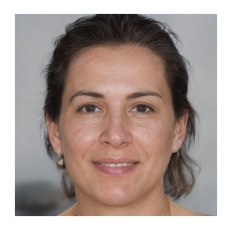

In [9]:
img, seed = gen_female.generate_seed()
img = gen_female.generate_image(seed, gen_female.G_ffhq, psi=0.5)
img = gen_female.add_border(img)
plt.imshow(img)
plt.axis('off')
plt.show()


In [12]:
import numpy as np

In [ ]:
target_source = '/content/drive/MyDrive/data/_kathi/target/own/13.png'
target_pil = PIL.Image.open(target_source).convert('RGB')
w, h = target_pil.size
s = min(w, h)
target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
target_pil = target_pil.resize((256, 256), PIL.Image.LANCZOS)
target_uint8 = np.array(target_pil, dtype=np.uint8)

device = torch.device('cuda')

target = torch.tensor(target_uint8.transpose([2, 0, 1]), device=device)
w = projector.project(gen_female.G_ffhq, target, num_steps=500, device=device, verbose=True)

In [ ]:
target_source = '/content/drive/MyDrive/data/_kathi/target/own/13.png'
target_pil = PIL.Image.open(target_source).convert('RGB')
latent = gen_female.find_latent(target_pil, 100)

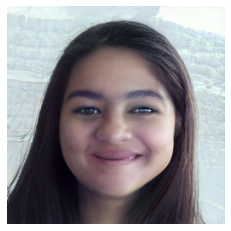

In [39]:
img = gen_female.generate_image_w(latent, gen_female.G_ffhq)
plt.imshow(img)
plt.axis('off')
plt.show()


In [30]:
w.shape

torch.Size([14, 512])

In [25]:
img_num = 13
c_seed = np.load(f'/content/drive/MyDrive/data/_kathi/latent_vectors/own/{img_num}/projected_w.npz')['w']
c_seed.shape

#img = gen_female.generate_image_w(c_seed, gen_female.G_ffhq)
#plt.imshow(img)
#plt.axis('off')
#plt.show()

(1, 14, 512)

# Gradio App

In [33]:
from IPython.lib.security import passwd
import numpy as np
from PIL import Image


def gen_image(image, features, iterations):

  gen = gen_female if features == 'feminine' else gen_male

  if image is None:
    img, seed = gen.generate_seed()
    images = gen.generate_art_styles(seed)
    return img, images
  else:
    pass

demo = gr.Interface(
    fn=gen_image,
    inputs=[
        gr.Image(),
        gr.Radio(["feminine", "masculine"], value="feminine"),
        gr.Slider(1, 1000, label='amount of iterations')
    ],
    outputs=[
        gr.Image(),
        gr.Image(),
    ]
)

demo.launch(share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.
